In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll
from scipy.special import expit
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import time
import scipy
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm 
from sklearn.linear_model import LogisticRegression

from numpy.random import default_rng
rng = default_rng()

# Mnist

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X_mnist = mnist.data.to_numpy()
y_mnist = mnist.target.to_numpy()

# Data generation

In [3]:
def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

def generateChessBoard(number_of_samples, dimensions=2, n_classes=2, noise=False):
    dimensions = dimensions**2
    x = np.random.uniform(-(dimensions // 2) * np.pi, (dimensions // 2) * np.pi, size=(number_of_samples, n_classes))
    mask = np.logical_or(np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
                         np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0))
    y = np.eye(n_classes)[1 * mask]

    if noise:
        for i in range(x.shape[0]):
            x[i, 0] += random.uniform(-0.5, 0.5)
            x[i, 1] += random.uniform(-0.5, 0.5)

    return x, y[:,0]

# Plot decision

In [4]:
def plotDecision(X, y, clf):
    fig, ax = plt.subplots(figsize=(15,15))
    grid = 100
    X1, X2 = np.meshgrid(np.linspace(np.min(X), np.max(X), grid), np.linspace(np.min(X), np.max(X), grid))
    pred = clf.predict(np.array([X1.ravel(), X2.ravel()]).T)
    pred = np.reshape(pred, (grid, grid))
    ax.contourf(X1, X2, pred, levels=[0.5, 2], cmap=cm.Greens, alpha=0.6)
    
    indexes = y==1
    ax.scatter(X[indexes, 0], X[indexes, 1], label="1", marker="*", c="green")
    ax.scatter(X[np.logical_not(indexes), 0], X[np.logical_not(indexes), 1], label="-1", marker="*", c="orange")
    plt.show()


# MLPBackprop

In [5]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def sigmoidPrime(x):
    return sigmoid(x)*(1.0-sigmoid(x))

class MLPbackprop():
    def __init__(self, layers):
        self.weights = []
        for i in range(1, len(layers) - 1):
            w = np.random.randn(layers[i-1] + 1, layers[i] + 1)
            self.weights.append(w)
        w = np.random.randn(layers[-2] + 1, layers[-1])
        self.weights.append(w)
        self.sizes = layers
        self.class_labels_ = None
        self.activ_func = scipy.special.expit
        
    def fit(self, X, Y, epochs=10, learning_rate=0.1):
        ones = np.ones(X.shape[0]).reshape(-1, 1)
        X = np.concatenate((ones, X), axis=1)
        Y = np.array(list(map(int, Y)))
        self.class_labels_ = np.unique(Y)
        for e in range(epochs):
            randomize = np.arange(X.shape[0])
            np.random.shuffle(randomize)
            X = X[randomize]
            Y = Y[randomize]
            for x, y in zip(X, Y):
                activations = [x]

                for layer in range(len(self.weights)):
                        dot_value = np.dot(activations[layer], self.weights[layer])
                        activation = self.activ_func(dot_value)
                        activations.append(activation)
                
                one_hot = np.zeros(activations[-1].shape[0])
                one_hot[y] = 1.0
                error = one_hot - activations[-1]
                deltas = [error * sigmoidPrime(activations[-1])]

                for layer in range(len(activations) - 2, 0, -1): 
                    deltas.append(deltas[-1].dot(self.weights[layer].T)*self.activ_func(activations[layer]))

                deltas.reverse()

                for i in range(len(self.weights)):
                    layer = np.atleast_2d(activations[i])
                    delta = np.atleast_2d(deltas[i])
                    self.weights[i] += learning_rate * layer.T.dot(delta)

    def predict_proba(self, x):
        activation = np.concatenate((np.ones(1).T, np.array(x)))
        for layer in range(0, len(self.weights)):
            activation = self.activ_func(np.dot(activation, self.weights[layer]))
        return activation
                    
    def predict(self, X):
        return np.array([self.class_labels_[np.argmax(self.predict_proba(x))] for x in X])

    

# MLPExtreme - Linear

In [75]:
class MLPExtremeLinear():
    def __init__(self, hidden_size=100):
        self.hidden_size = hidden_size
        self.coef_ = []
        self.intercepts_ = []
        self.activ_func = scipy.special.expit
        self.class_labels_ = None
        
    def fit(self, X, y):
        self.class_labels_ = np.unique(y)
        index = np.random.choice(np.arange(X.shape[0]), (self.hidden_size, 2))
        self.coef_.append(X[index[:, 0], :] - X[index[:, 1], :])
        self.intercepts_.append(np.sum(np.dot(self.coef_[0], X[index[:, 0], :].T), axis=0))
        
        V = (self.activ_func(np.dot(X, self.coef_[0].T) + self.intercepts_[0]))
        self.clf = LogisticRegression(solver='liblinear', C=100)
        self.clf.fit(V, y)
        
    def predict_proba(self, X):
        return self.activ_func(np.dot(X, self.coef_[0].T) + self.intercepts_[0])

    def predict(self, X):
        X = self.predict_proba(X)
        return self.clf.predict(X)

# MLPExtreme - Moore Penrose

In [76]:
class MLPExtreme():
    def __init__(self, hidden_size=100):
        self.hidden_size = hidden_size
        self.hidden_weights = None
        self.output_weights = None
        self.activ_func = scipy.special.expit
        self.class_labels_ = None
        self.biases = None
        
    def fit(self, X, y):
        y = np.array(list(map(int, y)))
        self.class_labels_ = np.unique(y)
        onehot = OneHotEncoder()
        y = onehot.fit_transform(y.reshape(-1, 1)).toarray()

        self.hidden_weights = np.random.randn(X.shape[1], self.hidden_size)
        self.biases = np.random.randn(self.hidden_size)
        
        H = self.activ_func(np.dot(X, self.hidden_weights) + self.biases)

        self.output_weights = np.dot(scipy.linalg.pinv(H), y)
    
    def predict_proba(self, X):
        H = self.activ_func(np.dot(X, self.hidden_weights) + self.biases)
        return np.dot(H, self.output_weights)   
        
    def predict(self, X):
        predictions = self.predict_proba(X)
        return [self.class_labels_[np.argmax(x)] for x in predictions]

# Example datasets

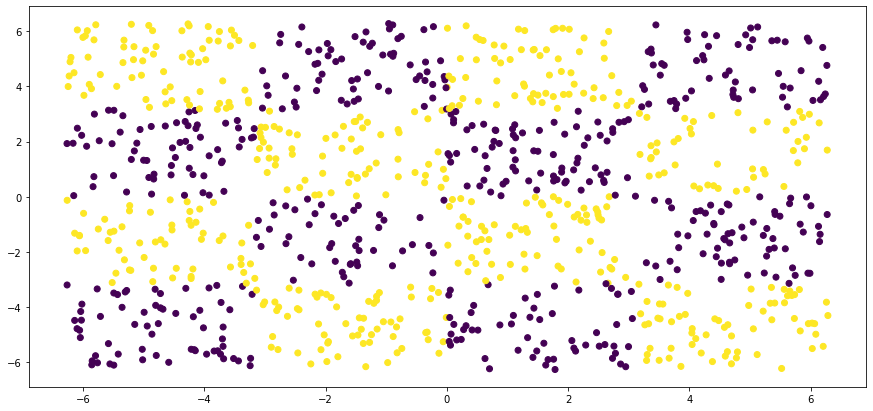

In [8]:
dataX, dataY = generateChessBoard(1000)
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dataX[:, 0], dataX[:,1], c=dataY)
plt.show()

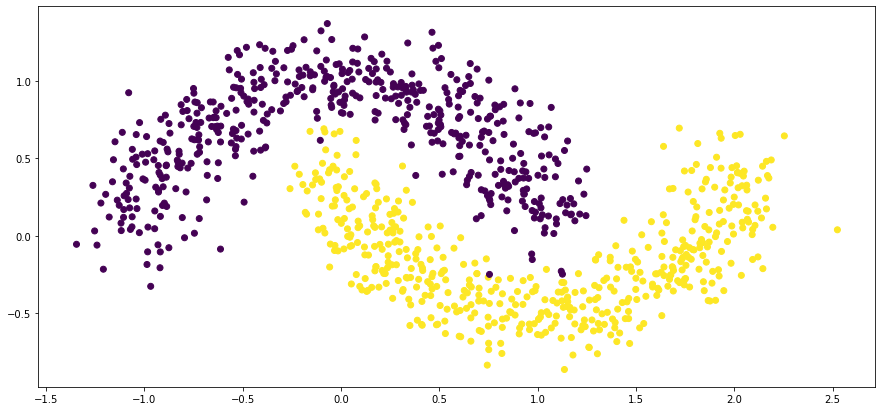

In [9]:
dataX, dataY = make_moons(1000, noise=0.15)
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dataX[:, 0], dataX[:,1], c=dataY)
plt.show()

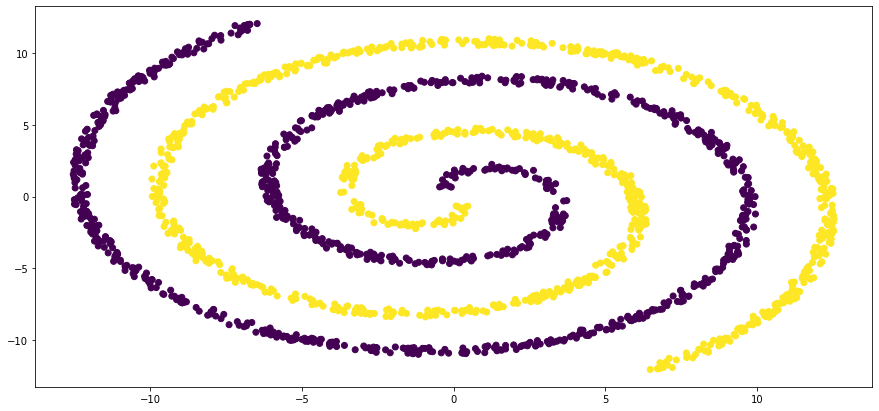

In [10]:
dataX, dataY = twospirals(1000)
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dataX[:, 0], dataX[:,1], c=dataY)
plt.show()

# Running 24 674 SKLearn Classifiers

In [98]:
df = pd.DataFrame(columns=["dataset", "m", "learn", "h", "K", "alpha", "solver", "fit_time", "predict_time", "AUC", "Accuracy", "F1_score"])

try:
    for m in [1000, 10000, 100000]:
        checkerboard_X, checkerboard_y = generateChessBoard(m)
        half_moon_X, half_moon_y = make_moons(m, noise=0.15)
        spirals_X, spirals_y = twospirals(m)
        for learn in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.10, 0.2, 0.5]:
            
            X_train_checkerboard, X_test_checkerboard, y_train_checkerboard, y_test_checkerboard = train_test_split(checkerboard_X, checkerboard_y, test_size=1-learn, random_state=42)
            X_train_half_moon, X_test_half_moon, y_train_half_moon, y_test_half_moon = train_test_split(half_moon_X, half_moon_y, test_size=1-learn, random_state=42)
            X_train_spirals, X_test_spirals, y_train_spirals, y_test_spirals = train_test_split(spirals_X, spirals_y, test_size=1-learn, random_state=42)

            for h in [1,2,3,4]:
                for K in [10, 30, 100, 300, 1000]:
                    for alpha in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]:
                        for solver in ["lbfgs", "adam"]:
                            hidden = [K for _ in range(h)]
                            
                            raise StopIteration
                            
                            # Checkerboard 
                            clf = MLPClassifier(hidden_layer_sizes=tuple(hidden), alpha=alpha, solver=solver)
                            start = time.perf_counter()
                            clf.fit(X_train_checkerboard, y_train_checkerboard)
                            time_fit = time.perf_counter() - start
                            
                            start = time.perf_counter()
                            y_pred = clf.predict(X_test_checkerboard)
                            time_predict = time.perf_counter() - start
                            
                            AUC_score = roc_auc_score(y_test_checkerboard, clf.predict_proba(X_test_checkerboard)[:, 1])
                            accuracy = accuracy_score(y_test_checkerboard, y_pred)
                            F1_Score = f1_score(y_test_checkerboard, y_pred)
                            
                            to_append = ["Checkerboard", m, learn, h, K, alpha, solver, time_fit, time_predict, AUC_score, accuracy, F1_Score]
                            series = pd.Series(to_append, index=df.columns)
                            df = df.append(series, ignore_index=True)
                            
                            
                            # Half Moons
                            clf = MLPClassifier(hidden_layer_sizes=tuple(hidden), alpha=alpha, solver=solver)
                            start = time.perf_counter()
                            clf.fit(X_train_half_moon, y_train_half_moon)
                            time_fit = time.perf_counter() - start
                            
                            start = time.perf_counter()
                            y_pred = clf.predict(X_test_half_moon)
                            time_predict = time.perf_counter() - start
                            
                            AUC_score = roc_auc_score(y_test_half_moon, clf.predict_proba(X_test_half_moon)[:, 1])
                            accuracy = accuracy_score(y_test_half_moon, y_pred)
                            F1_Score = f1_score(y_test_half_moon, y_pred)
                            
                            to_append = ["Half Moons", m, learn, h, K, alpha, solver, time_fit, time_predict, AUC_score, accuracy, F1_Score]
                            series = pd.Series(to_append, index=df.columns)
                            df = df.append(series, ignore_index=True)
                            
                            
                            # Spirals
                            clf = MLPClassifier(hidden_layer_sizes=tuple(hidden), alpha=alpha, solver=solver)
                            start = time.perf_counter()
                            clf.fit(X_train_spirals, y_train_spirals)
                            time_fit = time.perf_counter() - start
                            
                            start = time.perf_counter()
                            y_pred = clf.predict(X_test_spirals)
                            time_predict = time.perf_counter() - start
                            
                            AUC_score = roc_auc_score(y_test_spirals, clf.predict_proba(X_test_spirals)[:, 1])
                            accuracy = accuracy_score(y_test_spirals, y_pred)
                            F1_Score = f1_score(y_test_spirals, y_pred)
                            
                            to_append = ["Spirals", m, learn, h, K, alpha, solver, time_fit, time_predict, AUC_score, accuracy, F1_Score]
                            series = pd.Series(to_append, index=df.columns)
                            df = df.append(series, ignore_index=True)
                            
    df.to_csv("Output.csv", index=False)
except StopIteration: pass 



# MLPBackProp Test - MNIST

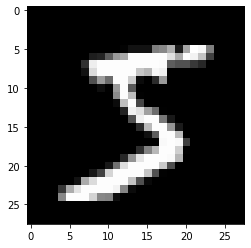

In [12]:
plt.imshow(X_mnist[0].reshape(28, 28), cmap="gray")
plt.show()

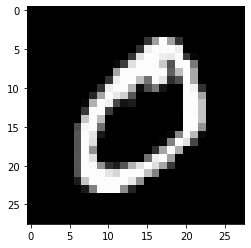

In [13]:
plt.imshow(X_mnist[1].reshape(28, 28), cmap="gray")
plt.show()

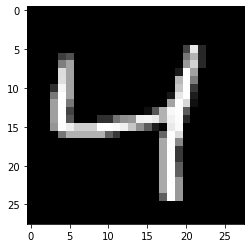

In [14]:
plt.imshow(X_mnist[2].reshape(28, 28), cmap="gray")
plt.show()

### Fitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.33, random_state=42)

nn = MLPbackprop([784,64,10])

start = time.perf_counter()
nn.fit(X_train, y_train)
print(f"Estimated fitting time: {np.round(time.perf_counter() - start, 3)} seconds")

Estimated fitting time: 112.571 seconds


### Predict

In [16]:
start = time.perf_counter()
y_pred = nn.predict(X_test)
print(f"Estimated predicting time: {np.round(time.perf_counter() - start, 3)} seconds")

Estimated predicting time: 2.254 seconds


### Accuracy

In [17]:
print(accuracy_score(list(map(int, y_test)), y_pred))

0.8667532467532467


# MLPExtreme - Linear

Accuracy: 0.993


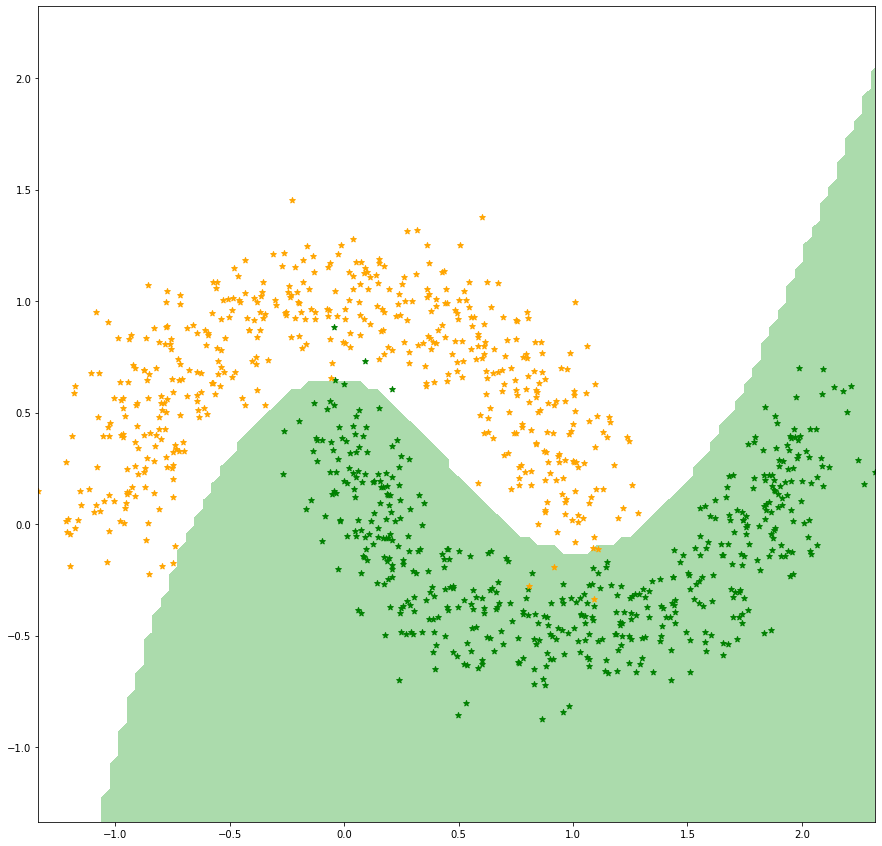

In [100]:
X, y = make_moons(1000, noise=0.15)
clf = MLPExtremeLinear(100)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

In [69]:
clf.coef_[0].shape

(100, 2)

Accuracy: 0.903


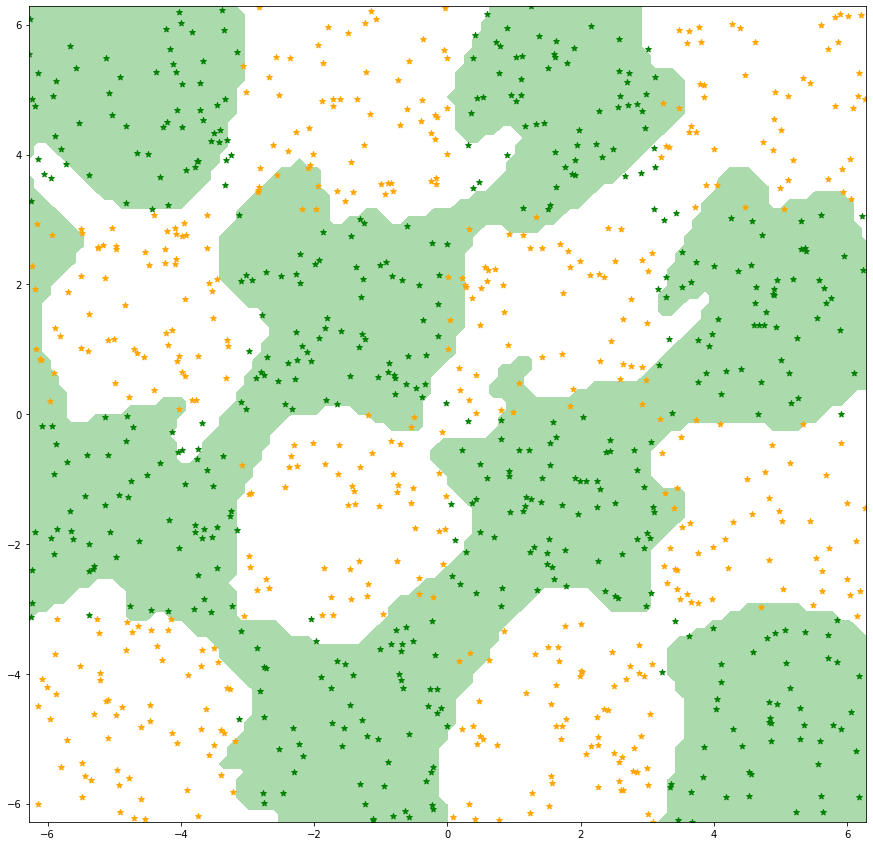

In [111]:
X, y = generateChessBoard(1000)
clf = MLPExtremeLinear(100)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

Accuracy: 0.8855


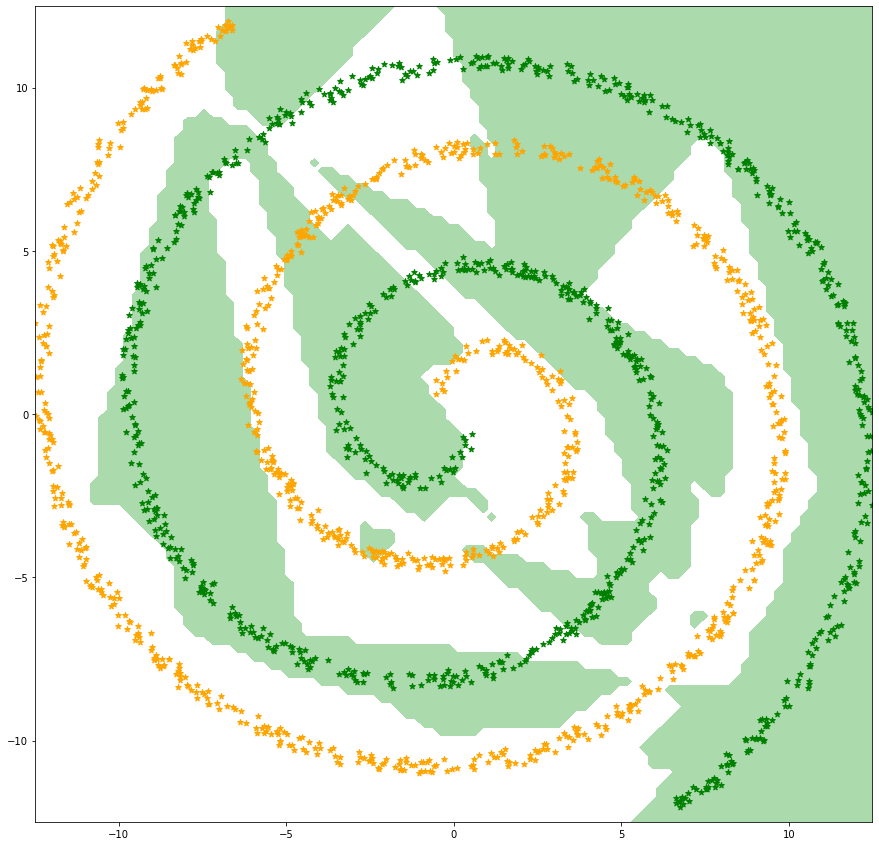

In [118]:
X, y = twospirals(1000)
clf = MLPExtremeLinear(100)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

# MLPExtreme - Moore Penrose

# Mnist

### Fitting

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.33, random_state=42)

nn = MLPExtreme(10000)

start = time.perf_counter()
nn.fit(X_train, y_train)
print(f"Estimated fitting time: {np.round(time.perf_counter() - start, 3)} seconds")

Estimated fitting time: 964.829 seconds


### Predict

In [22]:
start = time.perf_counter()
y_pred = nn.predict(X_test)
print(f"Estimated predicting time: {np.round(time.perf_counter() - start, 3)} seconds")

Estimated predicting time: 16.176 seconds


### Accuracy

In [23]:
print(accuracy_score(list(map(int, y_test)), y_pred))

0.9645454545454546


## Generated datasets

Accuracy: 1.0


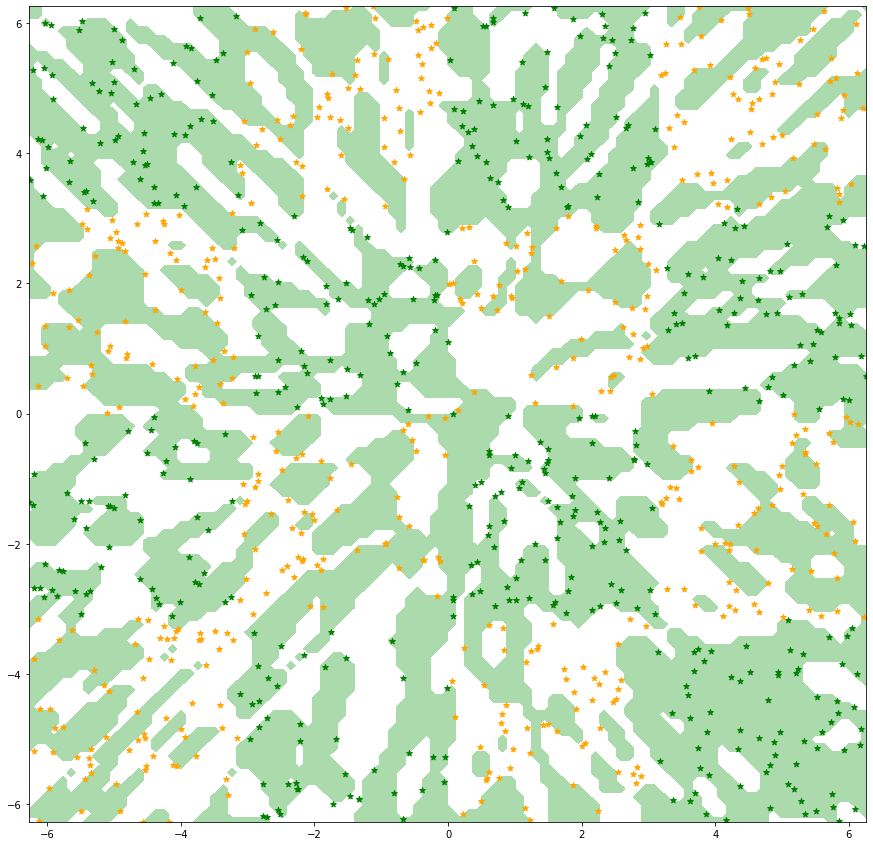

In [94]:
X, y = generateChessBoard(1000)
clf = MLPExtreme(10000)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

Accuracy: 0.995


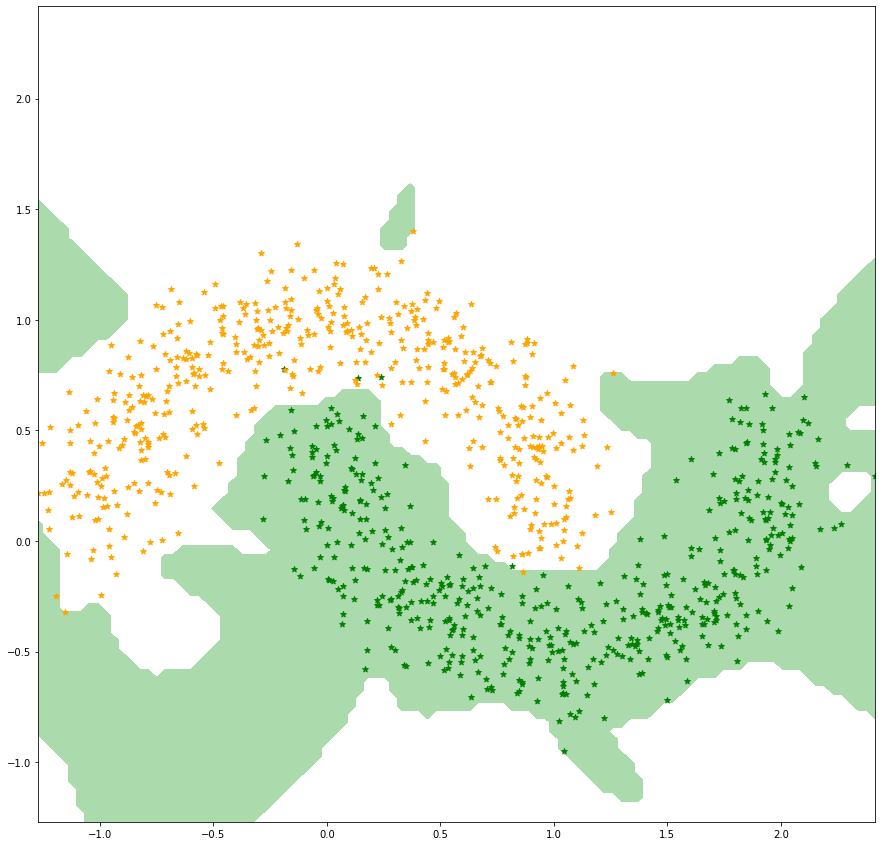

In [95]:
X, y = make_moons(1000, noise=0.15)
clf = MLPExtreme(10000)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

Accuracy: 1.0


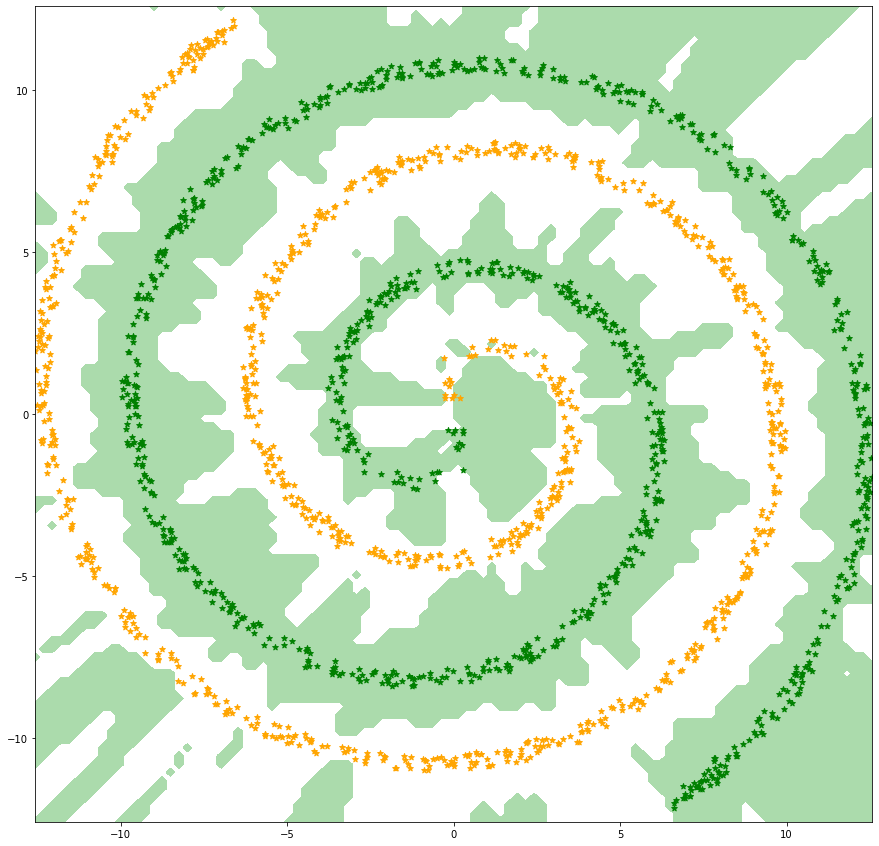

In [96]:
X, y = twospirals(1000)
clf = MLPExtreme(10000)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {accuracy_score(y, y_pred)}")

plotDecision(X, y, clf)

---

# Analyzing generated SKLearn classifiers

In [27]:
df = pd.read_csv("Results.csv")
df["n_coef"] = df.apply(lambda row: (row.h * row.K + 1) + (3*row.K + (row.K**2)*(row.h - 1)), axis=1)
df

,dataset,m,learn,h,K,alpha,solver,fit_time,predict_time,AUC,Accuracy,F1_score,n_coef
0,Checkerboard,1000,0.001,1,10,0.00001,lbfgs,0.006730,0.000525,0.499050,0.497497,0.664439,41
1,Half Moons,1000,0.001,1,10,0.00001,lbfgs,0.004723,0.000652,0.132172,0.499499,0.666222,41
2,Spirals,1000,0.001,1,10,0.00001,lbfgs,0.003496,0.000771,0.502768,0.499499,0.666222,41
3,Checkerboard,1000,0.001,1,10,0.00001,adam,0.061266,0.001009,0.522598,0.497497,0.664439,41
4,Half Moons,1000,0.001,1,10,0.00001,adam,0.062367,0.000950,0.096657,0.499499,0.666222,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24669,Checkerboard,100000,0.200,3,300,100.00000,adam,13.320727,0.708738,0.500000,0.498237,0.000000,181801
24670,Half Moons,100000,0.200,3,300,100.00000,adam,13.092266,0.712120,0.500000,0.498900,0.000000,181801
24671,Spirals,100000,0.200,3,300,100.00000,adam,24.354765,1.416761,0.500000,0.499837,0.000000,181801
24672,Checkerboard,100000,0.200,3,1000,0.00001,lbfgs,658.017014,4.163739,0.972876,0.907362,0.906919,2006001


In [28]:
df.groupby("dataset").mean()

,m,learn,h,K,alpha,fit_time,predict_time,AUC,Accuracy,F1_score,n_coef
dataset,,,,,,,,,,,
Checkerboard,33821.276596,0.081882,2.484498,286.701520,13.887200,11.378706,0.346306,0.733964,0.701104,0.671897,325615.054711
Half Moons,33821.276596,0.081882,2.484498,286.701520,13.887200,10.154853,0.332110,0.902957,0.851660,0.814524,325615.054711
Spirals,33813.229572,0.081868,2.484436,286.614786,13.888889,18.660243,0.693076,0.724171,0.680841,0.691950,325410.727626


In [29]:
df.loc[df["n_coef"] == df["n_coef"].min()].sort_values(["Accuracy"], ascending=False).groupby("dataset").head(10)

,dataset,m,learn,h,K,alpha,solver,fit_time,predict_time,AUC,Accuracy,F1_score,n_coef
22099,Half Moons,100000,0.050,1,10,0.01000,lbfgs,0.455791,0.011646,0.999477,0.990789,0.990786,41
24031,Half Moons,100000,0.200,1,10,1.00000,lbfgs,0.734553,0.007997,0.999427,0.990537,0.990550,41
24019,Half Moons,100000,0.200,1,10,0.01000,lbfgs,1.094587,0.008870,0.999425,0.990500,0.990513,41
24025,Half Moons,100000,0.200,1,10,0.10000,lbfgs,0.616874,0.008255,0.999450,0.990250,0.990262,41
23047,Half Moons,100000,0.100,1,10,0.00010,lbfgs,0.536851,0.009574,0.999488,0.990233,0.990231,41
24001,Half Moons,100000,0.200,1,10,0.00001,lbfgs,0.870007,0.008694,0.999472,0.990213,0.990229,41
23059,Half Moons,100000,0.100,1,10,0.01000,lbfgs,0.509296,0.009037,0.999472,0.990122,0.990121,41
24010,Half Moons,100000,0.200,1,10,0.00010,adam,5.117405,0.008606,0.999452,0.989912,0.989928,41
15385,Half Moons,10000,0.200,1,10,0.10000,lbfgs,0.225371,0.000998,0.999530,0.989875,0.989922,41
21145,Half Moons,100000,0.020,1,10,0.10000,lbfgs,0.296646,0.011683,0.999463,0.989827,0.989798,41


In [30]:
df.groupby(["n_coef"]).mean()

,m,learn,h,K,alpha,fit_time,predict_time,AUC,Accuracy,F1_score
n_coef,,,,,,,,,,
41,34576.923077,0.083231,1.0,10.0,13.888889,0.357988,0.005615,0.728598,0.663807,0.655489
121,34576.923077,0.083231,1.0,30.0,13.888889,0.524576,0.013599,0.755295,0.690672,0.683520
151,34576.923077,0.083231,2.0,10.0,13.888889,0.559282,0.010026,0.764256,0.710309,0.694850
261,34576.923077,0.083231,3.0,10.0,13.888889,0.634951,0.013903,0.775900,0.730230,0.707028
371,31960.000000,0.078560,4.0,10.0,13.888889,0.560408,0.018343,0.774237,0.732766,0.701100
401,34576.923077,0.083231,1.0,100.0,13.888889,1.311609,0.037118,0.767482,0.705824,0.698089
1051,34576.923077,0.083231,2.0,30.0,13.888889,0.895519,0.028955,0.793583,0.742816,0.728679
1201,34576.923077,0.083231,1.0,300.0,13.888889,3.175207,0.114751,0.776689,0.717459,0.709513
1981,34576.923077,0.083231,3.0,30.0,13.888889,1.081308,0.042193,0.802601,0.765853,0.743992
